## Import Libraries
- numpy
- kmodes (download kmodes library)
- pandas
- ast
- matplotlib
- seaborn

In [1]:
%pip install kmodes --quiet
%pip install gower --quiet
%pip install optuna --quiet
%pip install gower validclust --quiet
%pip install scikit-learn-extra --quiet
%pip install plotly --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import gower
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn


In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


## Load Data
Dataset of all NDRMMC tropical cyclone records from 2021-2025


https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv')
df.head()

,Typhoon Name,Year,Region,Province,City/Municipality,Families,Person,Brgy,Dead,Injured/Ill,Missing,Totally,Partially,Total,Quantity,Cost,Type,Category
0,AGATON,2022,8,LEYTE,ABUYOG,18957.0,68354.0,63.0,55.0,0.0,0.0,142.0,326.0,468.0,22690.0,13172269.32,"['BLANKET', 'BUTANE GAS STOVE', 'CANISTER', 'F...","['FAMILY FOOD PACK', 'HYGIENE KIT', 'KITCHEN K..."
1,AGATON,2022,6,ILOILO,AJUY,17414.0,61983.0,34.0,1.0,0.0,0.0,236.0,856.0,1092.0,4800.0,2948690,"['FAMILY FOOD PACK', 'FINANCIAL', 'HYGIENE KIT...","['FAMILY FOOD PACK', 'FINANCIAL / SOCIAL ASSIS..."
2,AGATON,2022,8,LEYTE,ALANGALANG,1323.0,5444.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,228.0,46740,['FAMILY FOOD PACK'],['FAMILY FOOD PACK']
3,AGATON,2022,8,LEYTE,ALBUERA,203.0,1008.0,0.0,NaN,NaN,NaN,5.0,0.0,5.0,NaN,NaN,NaN,NaN
4,AGATON,2022,6,ILOILO,ALIMODIAN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9228 entries, 0 to 9227
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Typhoon Name       9228 non-null   object 
 1   Year               9228 non-null   int64  
 2   Region             9228 non-null   object 
 3   Province           9228 non-null   object 
 4   City/Municipality  9206 non-null   object 
 5   Families           8704 non-null   float64
 6   Person             8704 non-null   float64
 7   Brgy               8704 non-null   float64
 8   Dead               507 non-null    float64
 9   Injured/Ill        507 non-null    float64
 10  Missing            507 non-null    float64
 11  Totally            3815 non-null   float64
 12  Partially          3815 non-null   float64
 13  Total              3815 non-null   float64
 14  Quantity           3638 non-null   float64
 15  Cost               3769 non-null   object 
 16  Type               3523 

## Data Preprocessing

### 1.1 Standardization of data

Fix column names for consistency and readability & convert all of them to lowercase snakecase




In [6]:
df.rename(columns={'Category': 'Category_Aid'}, inplace=True)


In [7]:
df.columns = df.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

print("Columns now:", list(df.columns))

Columns now: ['typhoon_name', 'year', 'region', 'province', 'city_municipality', 'families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'totally', 'partially', 'total', 'quantity', 'cost', 'type', 'category_aid']


In [8]:
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

Remove unnecessary columns
- type (baseline simplication basis of category)
- quantity (inconsistent values, same depth across all aids, not realiable)

In [9]:
df.drop(['type', 'quantity'], axis=1, inplace=True)

### 1.2 Handling Categorical & Impact Missing Values
Print the NaN/null values



In [10]:
df.isnull().sum()

typhoon_name            0
year                    0
region                  0
province                0
city_municipality      22
families              524
person                524
brgy                  524
dead                 8721
injured_ill          8721
missing              8721
totally              5413
partially            5413
total                5413
cost                 5462
category_aid         5714
dtype: int64

category -> replace NaN with ```['NOT SPECIFIED]```'

In [11]:
df['category_aid'] = df['category_aid'].fillna("['NOT SPECIFIED']")

city_municipality -> replace NaN with ```'UNKNOWN'```

In [12]:
df['city_municipality'] = df['city_municipality'].fillna('UNKNOWN')

impact-related columns ```(families, brgy, dead, injured_ill, missing, totally, partially, total)``` replace NaN with 0

In [13]:
zero_fill_cols = [
    'families', 'person', 'brgy',
    'dead', 'injured_ill', 'missing',
    'totally', 'partially', 'total'
]

df[zero_fill_cols] = df[zero_fill_cols].fillna(0)

In [14]:
# Count rows where 'person' is 0
zero_person_count = df[df['person'] == 0].shape[0]
print(f"Number of rows with 0 persons: {zero_person_count}")

# Remove rows where 'person' is 0
df = df[df['person'] > 0].copy()
print(f"Remaining rows after removal: {df.shape[0]}")

Number of rows with 0 persons: 980
Remaining rows after removal: 8248


In [15]:
for col in ['region', 'province', 'city_municipality']:
    df[col] = df[col].str.upper()

### 1.3 Verification Tagging
Events are tagged as either verified or unverified by the means of data

parse category column string to list

In [16]:
def parse_category(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x]
    except:
        return  ['NOT SPECIFIED']

df['category_aid'] = df['category_aid'].apply(parse_category)


**Verified events:** contain significant values in key columns (e.g. families, person, cost)

**Unverified events:** lacks significant values and having a unspecified categories (categories that equals to ```['NOT SPECIFIED']```, ```['NO BREAKDOWN']```, ```['FOR VERIFCATION']```)

In [17]:
category_counts = df['category_aid'].explode().value_counts()
print(category_counts)

category_aid
NOT SPECIFIED                            5194
FAMILY FOOD PACK                         2284
FINANCIAL / SOCIAL ASSISTANCE             670
OTHERS                                    602
HYGIENE KIT                               354
SLEEPING KIT                              288
NO BREAKDOWN                              169
KITCHEN KIT                               166
SHELTER KIT                               109
READY TO EAT FOOD                         105
FOR VERIFICATION                          103
CLOTHING KIT                               73
LOGISTICAL SUPPORT                         22
MEDICAL                                     6
READY TO EAT FOOD, LOGISTICAL SUPPORT       1
LIVELIHOOD                                  1
READY TO EAT FOOD, CLOTHING KIT             1
Name: count, dtype: int64


In [18]:
unverified_mask = df['category_aid'].apply(
    lambda x: any(item in ['NOT SPECIFIED', 'NO BREAKDOWN', 'FOR VERIFICATION'] for item in x)
)

In [19]:
unverified_mask.value_counts()

category_aid
True     5466
False    2782
Name: count, dtype: int64

### 1.4 Handling Missing Data using Unverified Masked

cost -> replace NaN with median cost (from tagged verified records only)

In [20]:
valid_cost_mask = ~unverified_mask & df['cost'].notna()
cost_median = df[valid_cost_mask]['cost'].median()

df.loc[~unverified_mask & df['cost'].isna(), 'cost'] = cost_median
df['cost'] = df['cost'].fillna(0) # final fallback

### 1.5 Simplication Mapping and Encoding of Category

*   Simplify and consolidate raw categories into fewer, more meaningful groups
*   Apply one-hot encoding to thematic varaibles for downstream analysis



In [21]:
def clean_and_split(lst):
    cleaned = []
    for item in lst:
        item = str(item).strip()
        # Handle combined: "READY TO EAT FOOD, CLOTHING KIT"
        if ',' in item and any(k in item for k in ['KIT', 'FOOD']):
            parts = [p.strip() for p in item.split(',') if p.strip()]
            cleaned.extend(parts)
        else:
            cleaned.append(item)
    return [c for c in cleaned if c not in ['', 'UNVERIFIED']]

# apply
df['category_aid'] = df['category_aid'].apply(clean_and_split)

In [22]:
# Mapping for normalization
mapping = {
    'NOT SPECIFIED': 'UNVERIFIED',
    'NO BREAKDOWN': 'UNVERIFIED',
    'FOR VERIFICATION': 'UNVERIFIED',
    'READY TO EAT FOOD': 'READY-TO-EAT MEALS',
    'CLOTHING KIT': 'CLOTHING',
    'LOGISTICAL SUPPORT': 'LOGISTICS',
    'MEDICAL': 'MEDICAL ASSISTANCE',
    'OTHERS': 'OTHER / UNSPECIFIED'
}

def standardize(item):
    return mapping.get(item.upper(), item.upper())  # normalize via mapping

def get_themes(items):
    themes = set()
    for item in items:
        item = standardize(item)
        if any(k in item for k in ['FAMILY FOOD PACK', 'READY-TO-EAT MEALS']):
            themes.add('Food')
        elif 'FINANCIAL' in item or 'SOCIAL ASSISTANCE' in item:
            themes.add('Cash')
        elif 'HYGIENE KIT' in item or 'MEDICAL ASSISTANCE' in item:
            themes.add('Hygiene & Health')
        elif 'SLEEPING KIT' in item or 'KITCHEN KIT' in item:
            themes.add('Sleeping Essentials')
        elif 'SHELTER KIT' in item or 'CLOTHING' in item or 'TARP' in item:
            themes.add('Shelter Support')
        elif 'LOGISTICS' in item:
            themes.add('Logistics')
        elif 'OTHER / UNSPECIFIED' in item:
            themes.add('Other')
        else:
            themes.add('Unverified')
    return list(themes)

# apply
df['aid_themes'] = df['category_aid'].apply(get_themes)

In [23]:
for theme in ['Food', 'Cash', 'Hygiene & Health', 'Sleeping Essentials', 'Shelter Support']:
    col_name = f'has_{theme.lower().replace(" & ", "_").replace(" ", "_")}'
    df[col_name] = df['aid_themes'].apply(lambda x: 1 if theme in x else 0)

In [24]:
# Show distribution of themes
all_themes = [t for themes in df['aid_themes'] for t in themes]
theme_counts = pd.Series(all_themes).value_counts()
print(theme_counts)

Unverified             5467
Food                   2323
Cash                    670
Other                   602
Hygiene & Health        356
Sleeping Essentials     327
Shelter Support         169
Logistics                23
Name: count, dtype: int64


In [25]:
df.drop(['aid_themes', 'category_aid'], axis=1, inplace=True)

In [ ]:
# df['region'] = df['region'].replace({'13': 'CARAGA'})

# df.loc[df['province'] == 'MISAMIS ORIENTAL', 'region'] = '10'
# df.loc[df['province'] == 'AGUSAN DEL NORTE', 'region'] = 'CARAGA'
# df.loc[df['province'] == 'SURIGAO DEL SUR', 'region'] = 'CARAGA'
# df.loc[df['province'] == 'SURIGAO DEL NORTE', 'region'] = 'CARAGA'
# df.loc[df['province'] == 'NEGROS ORIENTAL', 'region'] = '7'


In [27]:
df.head()

,typhoon_name,year,region,province,city_municipality,families,person,brgy,dead,injured_ill,missing,totally,partially,total,cost,has_food,has_cash,has_hygiene_health,has_sleeping_essentials,has_shelter_support
0,AGATON,2022,8,LEYTE,ABUYOG,18957.0,68354.0,63.0,55.0,0.0,0.0,142.0,326.0,468.0,13172269.32,1,0,1,1,0
1,AGATON,2022,6,ILOILO,AJUY,17414.0,61983.0,34.0,1.0,0.0,0.0,236.0,856.0,1092.0,2948690.00,1,1,1,1,0
2,AGATON,2022,8,LEYTE,ALANGALANG,1323.0,5444.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,46740.00,1,0,0,0,0
3,AGATON,2022,8,LEYTE,ALBUERA,203.0,1008.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.00,0,0,0,0,0
5,AGATON,2022,8,BILIRAN,ALMERIA,125.0,488.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0


## Feature Engineering

### 2.1 Transformation from Event-Based to Province-Based Data

*   Create a composite ID = ```(province, region)```

Aggregate data by composite ID:
* Sum ```(families, person, dead, injured_ill, missing, totally, partially, cost)```
* Mean ```(has_food, has_cash, has_hygiene_health, has_sleeping_essentials, has_shelter_support)```
* Count Number of typhoon events using nunique
* First and last year for recurrence rate, year min max







In [28]:
# --- Step 1. Clean and prepare typhoon names ---
df['typhoon_name_clean'] = df['typhoon_name'].str.strip()

# Create exploded version for individual typhoons
df['typhoon_list'] = df['typhoon_name_clean'].str.split('-')
df_exploded = df.explode('typhoon_list')
df_exploded['typhoon_list'] = df_exploded['typhoon_list'].str.strip()

# --- Step 2. Aggregation dictionary (without typhoon_name nunique here) ---
agg_dict = {
    # Impact & Damage (sum)
    'families': 'sum',
    'person': 'sum',
    'dead': 'sum',
    'injured_ill': 'sum',
    'missing': 'sum',
    'totally': 'sum',
    'partially': 'sum',
    'cost': 'sum',

    # Aid flags (mean across events)
    'has_food': 'sum',
    'has_cash': 'sum',
    'has_hygiene_health': 'sum',
    'has_sleeping_essentials': 'sum',
    'has_shelter_support': 'sum',

    # First and last year for recurrence rate
    'year': ['min', 'max'],
}

# --- Step 3. Province-level aggregation for impact & aid ---
province_df = df.groupby(['province', 'region']).agg(agg_dict).reset_index()

# Flatten column names after multi-level aggregation
province_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in province_df.columns]
province_df = province_df.rename(columns={
    'province': 'province_',
    'region': 'region_',
    'year_min': 'first_year',
    'year_max': 'last_year'
})

# --- Step 4. Province-level typhoon counts ---

# (a) Count unique report names (original merged names)
province_reports = (
    df.groupby(['province', 'region'])
      .agg({'typhoon_name_clean': 'nunique'})
      .reset_index()
      .rename(columns={'typhoon_name_clean': 'num_reports'})
)

# (b) Count unique individual typhoons (after split/explode)
province_typhoons = (
    df_exploded.groupby(['province', 'region'])
               .agg({'typhoon_list': 'nunique'})
               .reset_index()
               .rename(columns={'typhoon_list': 'num_typhoons'})
)

# --- Step 5. Merge into final province_df ---
province_df = (
    province_df
    .merge(province_reports, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .merge(province_typhoons, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .drop(columns=['province_x', 'region_x', 'province_y', 'region_y'])
)


In [29]:
province_df.head()

,province_,region_,families_sum,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,first_year,last_year,num_reports,num_typhoons
0,ABRA,CAR,191000.0,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,2021,2025,17,29
1,AGUSAN DEL NORTE,CARAGA,45045.0,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,2021,2025,7,9
2,AGUSAN DEL SUR,CARAGA,55722.0,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,2021,2024,4,5
3,AKLAN,6,170922.0,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,2021,2025,13,22
4,ALBAY,5,620755.0,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,2020,2025,16,25


### 2.2 Derived Features

*   new column for ```recurrence_rate``` = num of typhoons / (last year - first year + 1)
*   new column for ```cost_per_family``` = cost_sum / families_sum[link text](https://)



In [30]:
province_df['recurrence_rate'] = province_df['num_typhoons'] / (
    province_df['last_year'] - province_df['first_year'] + 1
)

In [31]:
province_df['cost_per_family'] = province_df.apply(
    lambda row: row['cost_sum'] / row['families_sum'] if row['families_sum'] > 0 else np.nan,
    axis=1
)

In [32]:
province_df.isnull().sum()

province_                      0
region_                        0
families_sum                   0
person_sum                     0
dead_sum                       0
injured_ill_sum                0
missing_sum                    0
totally_sum                    0
partially_sum                  0
cost_sum                       0
has_food_sum                   0
has_cash_sum                   0
has_hygiene_health_sum         0
has_sleeping_essentials_sum    0
has_shelter_support_sum        0
first_year                     0
last_year                      0
num_reports                    0
num_typhoons                   0
recurrence_rate                0
cost_per_family                0
dtype: int64

## Feature Selection
Building correlation matrix and removing
```families_sum, first_year, last_year, total```

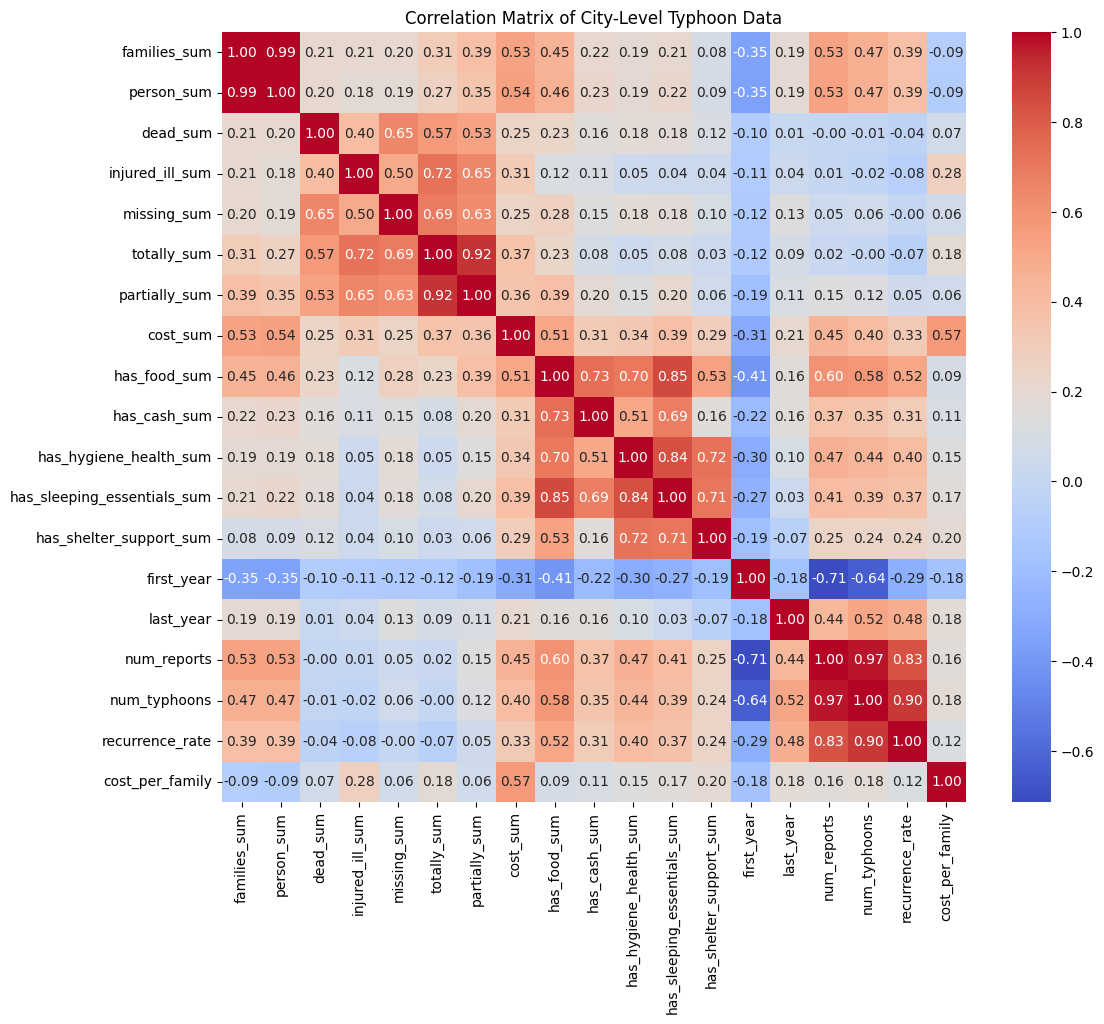

In [33]:
correlation_matrix = province_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of City-Level Typhoon Data')
plt.show()

In [34]:
province_df.drop(['families_sum', 'first_year', 'last_year', 'num_reports'], axis=1, inplace=True)


#### Changing the index to province + region

In [35]:
# Create a unique province-region ID
province_df['province_region'] = province_df['province_'] + ' (' + province_df['region_'] + ')'

# Set it as index (optional but clean)
province_df.set_index('province_region', inplace=True)

# Now drop the original 'province_' column
province_df.drop(columns=['province_'], inplace=True)

In [36]:
province_df.columns

Index(['region_', 'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
       'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum',
       'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum',
       'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate',
       'cost_per_family'],
      dtype='object')

In [37]:
province_df.head()

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,29,5.800000,154.257011
AGUSAN DEL NORTE (CARAGA),CARAGA,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,9,1.800000,451.313549
AGUSAN DEL SUR (CARAGA),CARAGA,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,5,1.250000,120.374087
AKLAN (6),6,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,22,4.400000,388.050105
ALBAY (5),5,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,25,4.166667,246.731259


In [38]:
province_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, ABRA (CAR) to ZAMBOANGA SIBUGAY (9)
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_                      92 non-null     object 
 1   person_sum                   92 non-null     float64
 2   dead_sum                     92 non-null     float64
 3   injured_ill_sum              92 non-null     float64
 4   missing_sum                  92 non-null     float64
 5   totally_sum                  92 non-null     float64
 6   partially_sum                92 non-null     float64
 7   cost_sum                     92 non-null     float64
 8   has_food_sum                 92 non-null     int64  
 9   has_cash_sum                 92 non-null     int64  
 10  has_hygiene_health_sum       92 non-null     int64  
 11  has_sleeping_essentials_sum  92 non-null     int64  
 12  has_shelter_support_sum      92 non-null     int64  
 13 

In [39]:
province_df.shape

(92, 16)

In [40]:
province_df.to_csv('province_typhoon_data_standard.csv', index=False)

In [41]:
province_df.describe()

,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
count,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.000000,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,7.701322e+05,8.684783,24.445652,1.010870,5988.869565,26503.510870,6.046428e+07,25.250000,7.282609,3.869565,3.554348,1.836957,16.717391,3.236775,351.582352
std,1.082292e+06,21.963471,64.763537,2.674645,18259.178563,72546.093399,8.770663e+07,34.555458,16.281403,6.702824,6.818469,4.289720,8.067471,1.175741,422.115878
min,4.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.750000,0.000000
25%,6.445600e+04,0.000000,0.000000,0.000000,46.500000,230.250000,2.761906e+06,2.000000,0.000000,0.000000,0.000000,0.000000,10.750000,2.250000,135.073876
50%,3.693375e+05,2.000000,1.000000,0.000000,216.000000,1510.500000,2.551739e+07,12.500000,1.500000,1.000000,1.000000,0.000000,16.000000,3.225000,263.429354
75%,9.645732e+05,6.250000,10.000000,0.250000,2393.250000,20713.250000,7.669189e+07,35.500000,5.000000,6.000000,5.000000,1.250000,24.000000,4.200000,431.329763
max,6.318463e+06,155.000000,374.000000,15.000000,127560.000000,580822.000000,4.775400e+08,205.000000,104.000000,46.000000,35.000000,28.000000,31.000000,5.800000,2463.921656


## EDA

## Model Training

#### Applying Standard Scaling

In [42]:
from sklearn.preprocessing import StandardScaler

final_df = province_df.copy()
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
print(f"numerical_columns: {numerical_cols}")

scaler = StandardScaler()
province_df[numerical_cols] = scaler.fit_transform(province_df[numerical_cols])

print("DataFrame after Standard Scaling:")
display(province_df.head())

numerical_columns: ['person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum', 'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate', 'cost_per_family']
DataFrame after Standard Scaling:


,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,-0.097266,-0.306027,1.405892,-0.380016,-0.326596,-0.355028,-0.355401,1.040238,2.391043,0.619600,0.065718,0.507002,1.530828,2.192040,-0.470029
AGUSAN DEL NORTE (CARAGA),CARAGA,-0.539307,-0.397586,-0.379528,-0.380016,-0.171417,-0.237385,-0.460111,-0.705616,-0.449747,-0.580467,-0.524139,-0.430569,-0.961848,-1.228713,0.237560
AGUSAN DEL SUR (CARAGA),CARAGA,-0.509796,-0.397586,-0.379528,-0.380016,-0.320593,-0.357536,-0.616274,-0.647421,-0.449747,-0.580467,-0.524139,-0.430569,-1.460383,-1.699067,-0.550738
AKLAN (6),6,-0.123357,-0.031349,-0.348478,-0.004086,-0.314756,-0.235251,0.067203,0.749262,1.711724,-0.430459,-0.081746,-0.430569,0.658392,0.994776,0.086866
ALBAY (5),5,1.516830,-0.122908,-0.270851,-0.380016,0.731738,1.095006,1.062671,0.778360,-0.326234,0.169575,0.360646,1.444573,1.032293,0.795232,-0.249755


### Labeling Categorical and Numerical Data Columns

In [43]:
province_df.columns = province_df.columns.str.strip()
province_df['region_'] = province_df['region_'].astype(str)

categorical_columns = ['region_']
categorical_indices = [province_df.columns.get_loc(col) for col in categorical_columns]

### Silhoutte Score

In [44]:
# Prepare data for Gower (exclude nothing yet — we'll drop 'cluster' later if present)
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()

print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

k_range = range(2, 12)
silhouette_scores = []
costs = []

print("\nRunning K-Prototypes for k = 2 to 10...")
for k in k_range:
    print(f"  k = {k} ...", end="")

    # Run K-Prototypes
    kproto = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=10,
        verbose=0,
        random_state=42
    )

    X = province_df.drop(columns=['cluster'], errors='ignore').values.astype(object)
    clusters = kproto.fit_predict(X, categorical=categorical_indices)

    # Compute silhouette score using precomputed Gower distance
    sil_score = silhouette_score(gower_dist, clusters, metric='precomputed')

    # Store results
    silhouette_scores.append(sil_score)
    costs.append(kproto.cost_)

    print(f" Silhouette = {sil_score:.4f}, Cost = {kproto.cost_:.2f}")


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!

Running K-Prototypes for k = 2 to 10...
  k = 2 ... Silhouette = 0.4448, Cost = 1088.76
  k = 3 ... Silhouette = 0.3422, Cost = 922.96
  k = 4 ... Silhouette = 0.2124, Cost = 755.82
  k = 5 ... Silhouette = 0.2302, Cost = 667.27
  k = 6 ... Silhouette = 0.2326, Cost = 577.81
  k = 7 ... Silhouette = 0.1994, Cost = 518.32
  k = 8 ... Silhouette = 0.1519, Cost = 480.59
  k = 9 ... Silhouette = 0.1649, Cost = 430.41
  k = 10 ... Silhouette = 0.1512, Cost = 386.11
  k = 11 ... Silhouette = 0.2032, Cost = 382.77


### Grid Search

In [45]:

param_grid = {
    'n_clusters': range(2, 11),  # Number of clusters to test
    'init': ['Huang', 'Cao'],   # Initialization methods
    'n_init': [5, 10]          # Number of initializations
}

# Create a list of parameter combinations
grid = ParameterGrid(param_grid)

best_score = -1
best_params = None
results = []

print("Starting Grid Search for K-Prototypes...")
print("-" * 30)

# Prepare the data (Include data prep from the previous successful cell)
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

# Separate numerical and categorical data
X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

# Combine the data for K-Prototypes. K-Prototypes expects categorical features last.
X = np.concatenate((X_numerical, X_categorical), axis=1)

# Get the indices of categorical columns in the combined matrix
# They will be after all numerical columns
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance matrix (if using precomputed metric for silhouette)
# Make sure 'gower_dist' is computed before the loop if metric='precomputed'
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy() # Re-create if needed
print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower) # Compute if needed
print("Gower distance computed!")


for params in grid:
    n_clusters = params['n_clusters']
    init_method = params['init']
    n_init = params['n_init']

    print(f"Testing params: k={n_clusters}, init='{init_method}', n_init={n_init}")

    try:
        # Initialize and train K-Prototypes model
        kp = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            verbose=0, # Set verbose to 0 for cleaner grid search output
            random_state=42
        )
        clusters = kp.fit_predict(X, categorical=categorical_indices_combined)
        score = silhouette_score(gower_dist, clusters, metric='precomputed')


        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': score,
            'cost': kp.cost_
        })

        print(f"  Silhouette Score: {score:.4f}, Cost: {kp.cost_:.2f}")

        # Check for best score
        if score > best_score:
            best_score = score
            best_params = params

    except Exception as e:
        print(f"  Error with params {params}: {e}")
        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': None,
            'cost': None,
            'error': str(e)
        })


print("-" * 30)
print("\nGrid Search Complete.")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Optional: Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='silhouette_score', ascending=False))

# Restore warnings
warnings.filterwarnings("default", category=DeprecationWarning)
warnings.filterwarnings("default", category=UserWarning)

Starting Grid Search for K-Prototypes...
------------------------------
Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!
Testing params: k=2, init='Huang', n_init=5
  Silhouette Score: 0.3447, Cost: 1090.74
Testing params: k=2, init='Huang', n_init=10
  Silhouette Score: 0.4448, Cost: 1088.76
Testing params: k=3, init='Huang', n_init=5
  Silhouette Score: 0.3422, Cost: 922.96
Testing params: k=3, init='Huang', n_init=10
  Silhouette Score: 0.3422, Cost: 922.96
Testing params: k=4, init='Huang', n_init=5
  Silhouette Score: 0.2124, Cost: 755.82
Testing params: k=4, init='Huang', n_init=10
  Silhouette Score: 0.2124, Cost: 755.82
Testing params: k=5, init='Huang', n_init=5
  Silhouette Score: 0.2302, Cost: 667.27
Testing params: k=5, init='Huang', n_init=10
  Silhouette Score: 0.2302, Cost: 667.27
Testing params: k=6, init='Huang', n_init=5
  Silhouette Score: 0.2326, Cost: 577.81
Testing params: k=6, init='Huang', n_init=10
  Silhouette Score: 0.

,n_clusters,init,n_init,silhouette_score,cost
1,2,Huang,10,0.444764,1088.758908
19,2,Cao,10,0.422043,1087.714561
18,2,Cao,5,0.360174,1090.289307
21,3,Cao,10,0.359709,910.554056
0,2,Huang,5,0.344723,1090.737202
2,3,Huang,5,0.342206,922.963233
3,3,Huang,10,0.342206,922.963233
27,6,Cao,10,0.251414,587.583336
26,6,Cao,5,0.251414,587.583336
25,5,Cao,10,0.234398,655.682401


### Optuna Bayesian / Smart Search

In [46]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


In [47]:
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance once for silhouette
print("Computing Gower distance matrix (one-time, may take a moment)...")
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

def objective(trial):
    # n_clusters = trial.suggest_int("n_clusters", 2, 10)  # cluster range
    n_clusters = 3
    init_method = trial.suggest_categorical("init", ["Huang", "Cao"])
    n_init = trial.suggest_int("n_init", 5, 15)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)  # categorical weight

    try:
        model = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            gamma=gamma,
            verbose=0,
            random_state=42
        )
        clusters = model.fit_predict(X, categorical=categorical_indices_combined)

        # Use silhouette with precomputed Gower distance
        score = silhouette_score(gower_dist, clusters, metric="precomputed")
        return score

    except Exception as e:
        # Failures return very low score
        return -1.0

# Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # try 50 trials


print("\n📊 Optuna Search Complete!")
print("Best Silhouette Score:", study.best_value)
print("Best Parameters:", study.best_trial.params)

optuna_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
optuna_results = optuna_results.sort_values(by="value", ascending=False)
display(optuna_results.head(20))


[I 2025-10-08 07:56:21,586] A new study created in memory with name: no-name-a8c5800a-a72c-414d-bd31-5b9b097dae53


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!


[I 2025-10-08 07:56:21,997] Trial 0 finished with value: 0.3597092032432556 and parameters: {'init': 'Cao', 'n_init': 11, 'gamma': 2.423509043090404}. Best is trial 0 with value: 0.3597092032432556.
[I 2025-10-08 07:56:22,273] Trial 1 finished with value: 0.3597092032432556 and parameters: {'init': 'Cao', 'n_init': 9, 'gamma': 4.782845967567736}. Best is trial 0 with value: 0.3597092032432556.
[I 2025-10-08 07:56:22,729] Trial 2 finished with value: 0.3422064483165741 and parameters: {'init': 'Huang', 'n_init': 12, 'gamma': 1.1769841247743833}. Best is trial 0 with value: 0.3597092032432556.
[I 2025-10-08 07:56:23,081] Trial 3 finished with value: 0.25493261218070984 and parameters: {'init': 'Huang', 'n_init': 10, 'gamma': 2.063430822084058}. Best is trial 0 with value: 0.3597092032432556.
[I 2025-10-08 07:56:23,231] Trial 4 finished with value: 0.19429180026054382 and parameters: {'init': 'Cao', 'n_init': 5, 'gamma': 0.9228274152205004}. Best is trial 0 with value: 0.3597092032432556.


📊 Optuna Search Complete!
Best Silhouette Score: 0.4013415277004242
Best Parameters: {'init': 'Cao', 'n_init': 15, 'gamma': 0.27021284069067475}


,number,value,params_gamma,params_init,params_n_init,state
12,12,0.401342,0.129297,Cao,15,COMPLETE
11,11,0.401342,0.270530,Cao,15,COMPLETE
10,10,0.401342,0.270213,Cao,15,COMPLETE
41,41,0.401342,0.129158,Cao,15,COMPLETE
44,44,0.401342,0.328998,Cao,15,COMPLETE
42,42,0.401342,0.104346,Cao,15,COMPLETE
47,47,0.401342,0.300311,Cao,15,COMPLETE
31,31,0.401342,0.146510,Cao,15,COMPLETE
32,32,0.401342,0.413220,Cao,15,COMPLETE
21,21,0.401342,0.171978,Cao,15,COMPLETE


In [48]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Make a copy so original province_df stays safe ---
province_df_kmeans = province_df.copy()

# Separate numerical + categorical (same as in KPrototypes)
numerical_cols = province_df_kmeans.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df_kmeans.select_dtypes(include="object").columns.tolist()

X_num = province_df_kmeans[numerical_cols].values
region = province_df_kmeans[categorical_cols].values  # assumes "Region" is in object dtype

# =========================
# One-Hot Encoding + KMeans
# =========================
ohe = OneHotEncoder(sparse_output=False, drop='first')
region_ohe = ohe.fit_transform(region)

# Combine numerical + one-hot encoded categorical
X_ohe = np.hstack([X_num, region_ohe])

# Train KMeans (clusters = 3 to match KPrototypes)
kmeans_ohe = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_ohe_labels = kmeans_ohe.fit_predict(X_ohe)

# Evaluate silhouette
silhouette_ohe = silhouette_score(X_ohe, kmeans_ohe_labels)
province_df_kmeans["kmeans_ohe_cluster"] = kmeans_ohe_labels
print(f"KMeans (One-Hot Encoded Region) Silhouette Score: {silhouette_ohe:.3f}")


# =========================
# Label Encoding + KMeans
# =========================
le = LabelEncoder()
region_le = le.fit_transform(region.ravel()).reshape(-1, 1)

# Combine numerical + label encoded categorical
X_le = np.hstack([X_num, region_le])

# Train KMeans
kmeans_le = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_le_labels = kmeans_le.fit_predict(X_le)

# Evaluate silhouette
silhouette_le = silhouette_score(X_le, kmeans_le_labels)
province_df_kmeans["kmeans_le_cluster"] = kmeans_le_labels
print(f"KMeans (Label Encoded Region) Silhouette Score: {silhouette_le:.3f}")

KMeans (One-Hot Encoded Region) Silhouette Score: 0.501
KMeans (Label Encoded Region) Silhouette Score: 0.355



=== Clustering Comparison (with Gower for K-Prototypes) ===
K-Prototypes (Gower)        : 0.144
KMeans (One-Hot Encoded)    : 0.501
KMeans (Label Encoded)      : 0.355


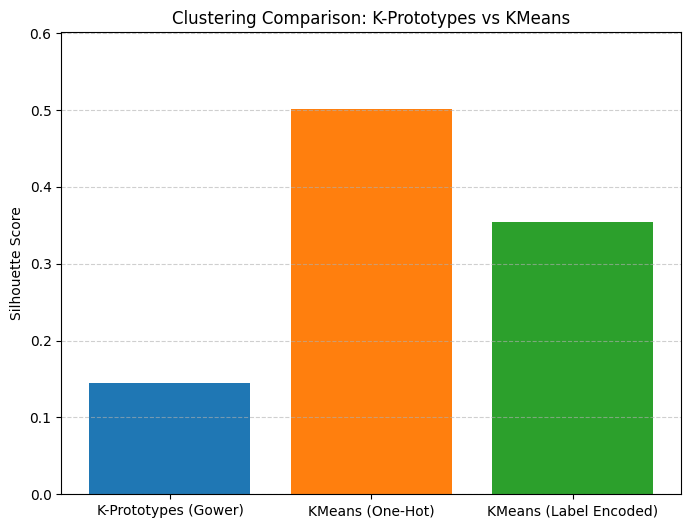

In [49]:
# --- Gower distance for mixed data ---
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)

# --- Proper silhouette score for K-Prototypes ---
silhouette_kproto = silhouette_score(
    gower_dist,
    clusters,  # from your final KPrototypes model
    metric="precomputed"
)

print("\n=== Clustering Comparison (with Gower for K-Prototypes) ===")
print(f"K-Prototypes (Gower)        : {silhouette_kproto:.3f}")
print(f"KMeans (One-Hot Encoded)    : {silhouette_ohe:.3f}")
print(f"KMeans (Label Encoded)      : {silhouette_le:.3f}")

# --- Bar Chart Comparison ---
scores = {
    "K-Prototypes (Gower)": silhouette_kproto,
    "KMeans (One-Hot)": silhouette_ohe,
    "KMeans (Label Encoded)": silhouette_le,
}

plt.figure(figsize=(8,6))
plt.bar(scores.keys(), scores.values(), color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.ylabel("Silhouette Score")
plt.title("Clustering Comparison: K-Prototypes vs KMeans")
plt.ylim(0, max(scores.values())+0.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


#### Training the model kprototypes

In [50]:
from kmodes.kprototypes import KPrototypes

# --- 1. Get best parameters from Optuna ---
best_params = study.best_trial.params
print("Best Params:", best_params)

# --- 2. Prepare your data again (same as before) ---
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include="object").columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

# Concatenate numerical + categorical
X = np.concatenate((X_numerical, X_categorical), axis=1)

# Indices of categorical features
categorical_indices = list(range(X_numerical.shape[1], X.shape[1]))

# --- 3. Fit the final K-Prototypes model ---
kproto_final = KPrototypes(
    n_clusters=3,  # 👈 fixed based on your earlier decision
    init=best_params.get("init", "Cao"),
    n_init=best_params.get("n_init", 10),
    gamma=best_params.get("gamma", None),  # only if Optuna tuned gamma
    random_state=42,
    verbose=1
)

clusters = kproto_final.fit_predict(X, categorical=categorical_indices)

# --- 4. Add cluster labels back to the dataframe ---
final_df["cluster"] = clusters

print("\n✅ Final K-Prototypes model trained!")
province_df.head()


Best Params: {'init': 'Cao', 'n_init': 15, 'gamma': 0.27021284069067475}
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 30, ncost: 936.2154048292588
Run: 1, iteration: 2/100, moves: 8, ncost: 919.8170163633638
Run: 1, iteration: 3/100, moves: 0, ncost: 919.8170163633638
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3, ncost: 1002.2331794749416
Run: 2, iteration: 2/100, moves: 1, ncost: 1001.0436477599875
Run: 2, iteration: 3/100, moves: 0, ncost: 1001.0436477599875
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 6, ncost: 996.4310425309968
Run: 3, iteration: 2/100, moves: 2, ncost: 969.8989630617066
Run: 3, iteration: 3/100, moves: 0, ncost: 969.8989630617066
Init: initializing centroids
Init: initializing clusters
S

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,-0.097266,-0.306027,1.405892,-0.380016,-0.326596,-0.355028,-0.355401,1.040238,2.391043,0.619600,0.065718,0.507002,1.530828,2.192040,-0.470029
AGUSAN DEL NORTE (CARAGA),CARAGA,-0.539307,-0.397586,-0.379528,-0.380016,-0.171417,-0.237385,-0.460111,-0.705616,-0.449747,-0.580467,-0.524139,-0.430569,-0.961848,-1.228713,0.237560
AGUSAN DEL SUR (CARAGA),CARAGA,-0.509796,-0.397586,-0.379528,-0.380016,-0.320593,-0.357536,-0.616274,-0.647421,-0.449747,-0.580467,-0.524139,-0.430569,-1.460383,-1.699067,-0.550738
AKLAN (6),6,-0.123357,-0.031349,-0.348478,-0.004086,-0.314756,-0.235251,0.067203,0.749262,1.711724,-0.430459,-0.081746,-0.430569,0.658392,0.994776,0.086866
ALBAY (5),5,1.516830,-0.122908,-0.270851,-0.380016,0.731738,1.095006,1.062671,0.778360,-0.326234,0.169575,0.360646,1.444573,1.032293,0.795232,-0.249755


In [51]:
final_df['cluster'].value_counts()

cluster
0    79
1     7
2     6
Name: count, dtype: int64

#### Showing the values

In [52]:
# Filter the DataFrame to show only cluster 2
cluster_2_df = final_df[final_df['cluster'] == 2]

# Display the filtered DataFrame
display(cluster_2_df)

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family,cluster
province_region,,,,,,,,,,,,,,,,,
BOHOL (7),7,1432311.0,90.0,94.0,15.0,93635.0,206502.0,1.580699e+08,52,1,0,0,0,10,2.000000,362.544085,2
CEBU (7),7,2594151.0,58.0,362.0,11.0,127560.0,580822.0,1.081306e+08,61,2,0,0,0,18,3.000000,127.263056,2
LEYTE (8),8,1134022.0,155.0,22.0,1.0,17525.0,77914.0,6.590729e+07,30,11,10,8,5,12,3.000000,221.519224,2
MAGUINDANAO (BARMM),BARMM,1388101.0,65.0,164.0,13.0,1064.0,1187.0,0.000000e+00,19,0,7,5,7,11,2.200000,0.000000,2
NEGROS ORIENTAL (7),7,535138.0,66.0,91.0,6.0,24412.0,109147.0,6.545572e+07,27,0,0,0,0,14,2.333333,418.785264,2
SURIGAO DEL NORTE (CARAGA),CARAGA,677806.0,19.0,374.0,0.0,47993.0,69983.0,3.585277e+08,1,12,0,0,0,11,2.200000,1977.298268,2


### Evaluation

In [53]:
# ==========================================================
# 📌 Cluster Evaluation (Silhouette, DBI, Dunn, McClain)
# ==========================================================
import gower
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn

# --- Custom McClain Index ---
def mcclain_index(distance_matrix, labels):
    """
    McClain Index = (avg intra-cluster distance) / (avg inter-cluster distance)
    Lower is better.
    """
    labels = np.array(labels)
    n = len(labels)

    intra_dists = []
    inter_dists = []

    for i in range(n):
        for j in range(i + 1, n):
            if labels[i] == labels[j]:
                intra_dists.append(distance_matrix[i, j])
            else:
                inter_dists.append(distance_matrix[i, j])

    intra_mean = np.mean(intra_dists) if intra_dists else 0
    inter_mean = np.mean(inter_dists) if inter_dists else 1  # avoid div0
    return intra_mean / inter_mean

# --- 1. Prepare data for evaluation ---
X_eval = final_df.drop(columns=["cluster"], errors="ignore")

# Convert categorical cols to string (needed for Gower)
for col in categorical_cols:
    X_eval[col] = X_eval[col].astype(str)

# --- 2. Compute Gower distance (for all metrics) ---
print("Computing Gower distance matrix for evaluation...")
gower_dist = gower.gower_matrix(X_eval)
print("Gower distance computed!")

# --- 3. Extract numeric part (for DBI only) ---
X_num = final_df[numerical_cols].values

# --- 4. Compute metrics ---
results = {}

# Silhouette using Gower distance (higher = better)
results['Silhouette (Gower)'] = silhouette_score(gower_dist, final_df["cluster"], metric='precomputed')

# Davies-Bouldin Index (lower = better) - uses Euclidean on numerical features
results['Davies-Bouldin'] = davies_bouldin_score(X_num, final_df["cluster"])

# Dunn Index (higher = better)
results['Dunn'] = dunn(gower_dist, final_df["cluster"])

# McClain Index (lower = better)
results['McClain'] = mcclain_index(gower_dist, final_df["cluster"])

# --- 5. Print results ---
print("\n" + "="*50)
print("      CLUSTER EVALUATION METRICS")
print("="*50)
for metric, score in results.items():
    # Add interpretation
    if metric == 'Silhouette (Gower)':
        interpretation = "Higher is better (range: -1 to 1)"
    elif metric == 'Davies-Bouldin':
        interpretation = "Lower is better (0 to ∞)"
    elif metric == 'Dunn':
        interpretation = "Higher is better (0 to ∞)"
    elif metric == 'McClain':
        interpretation = "Lower is better (0 to ∞)"
    else:
        interpretation = ""

    print(f"{metric:.<30} {score:.4f}  ({interpretation})")
print("="*50)

Computing Gower distance matrix for evaluation...
Gower distance computed!

      CLUSTER EVALUATION METRICS
Silhouette (Gower)............ 0.4013  (Higher is better (range: -1 to 1))
Davies-Bouldin................ 1.8530  (Lower is better (0 to ∞))
Dunn.......................... 0.3081  (Higher is better (0 to ∞))
McClain....................... 0.4862  (Lower is better (0 to ∞))


### MAACLI Framework

In [54]:
final_df.columns = final_df.columns.str.strip()  # remove whitespace
final_df['region_'] = final_df['region_'].astype(str)  # categorical as string

# Only keep region as categorical (province_ is an ID, not useful for learning)
categorical_cols = ['region_']
numeric_cols = [col for col in final_df.columns if col not in categorical_cols + ['province_', 'cluster']]

# Encode categorical for ML
df_encoded = final_df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

X = df_encoded[numeric_cols + categorical_cols]
y = df_encoded["cluster"]

# Train XGBoost
xgb = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200, random_state=42)
xgb.fit(X, y)

# Feature importance
print("Feature Importances:", xgb.feature_importances_)


perm_importance = permutation_importance(
    xgb, X, y,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

# Show top features per cluster (simplified)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

print("\n=== GLOBAL FEATURE IMPORTANCE ===")
print(importance_df)


Feature Importances: [0.         0.2720517  0.04108698 0.         0.07964785 0.01087662
 0.03379524 0.07806544 0.         0.03127494 0.30383527 0.01827355
 0.0242136  0.05466063 0.02519034 0.02702797]

=== GLOBAL FEATURE IMPORTANCE ===
                        feature  importance
1                      dead_sum    0.104348
10  has_sleeping_essentials_sum    0.071739
2               injured_ill_sum    0.000000
0                    person_sum    0.000000
4                   totally_sum    0.000000
5                 partially_sum    0.000000
6                      cost_sum    0.000000
3                   missing_sum    0.000000
7                  has_food_sum    0.000000
8                  has_cash_sum    0.000000
9        has_hygiene_health_sum    0.000000
11      has_shelter_support_sum    0.000000
12                 num_typhoons    0.000000
13              recurrence_rate    0.000000
14              cost_per_family    0.000000
15                      region_    0.000000


In [55]:
# Prepare data for tree (encode categorical)
df_explain = final_df.copy()
df_explain['region_'] = df_explain['region_'].astype('category').cat.codes  # encode

# Features + target
X_tree = df_explain.drop(columns=['province_', 'cluster'], errors='ignore')
y_tree = df_explain['cluster']

# Train a shallow decision tree (for interpretability)
tree = DecisionTreeClassifier(
    max_depth=4,          # keep it simple
    min_samples_leaf=5,   # avoid overfitting
    random_state=42
)
tree.fit(X_tree, y_tree)

# Extract rules per cluster
rules = export_text(tree, feature_names=list(X_tree.columns))
print("=== DECISION TREE RULES ===")
print(rules)

=== DECISION TREE RULES ===
|--- dead_sum <= 13.00
|   |--- has_hygiene_health_sum <= 10.50
|   |   |--- class: 0
|   |--- has_hygiene_health_sum >  10.50
|   |   |--- class: 0
|--- dead_sum >  13.00
|   |--- has_sleeping_essentials_sum <= 8.50
|   |   |--- class: 2
|   |--- has_sleeping_essentials_sum >  8.50
|   |   |--- class: 1



In [56]:
# Features you always want to add to descriptions
extra_features = [
    'has_hygiene_health_sum',
    'has_sleeping_essentials_sum',
    'has_shelter_support_sum',
    'recurrence_rate'
]

# Predefined cluster interpretations
cluster_labels = {
    0: "Moderate-Impact Typhoons",
    1: "High-Casualty Typhoons",
    2: "Low-Impact Typhoons"
}

def describe_cluster(df, cluster_id, important_features, top_k=3):
    subset = df[df['cluster'] == cluster_id]

    # Add cluster title and interpretation label
    desc = f"**Cluster {cluster_id} – {cluster_labels.get(cluster_id, 'Unlabeled')}**\n"

    # Core features = top_k important + extras (unique)
    features_to_describe = list(dict.fromkeys(important_features[:top_k] + extra_features))

    # Add feature-based description
    for feat in features_to_describe:
        if feat in df.columns:  # only describe if exists in data
            if df[feat].dtype in ['object', 'category']:
                mode_val = subset[feat].mode().iloc[0] if not subset[feat].mode().empty else "N/A"
                desc += f"- {feat}: mostly '{mode_val}'\n"
            else:
                q1 = subset[feat].quantile(0.25)
                q3 = subset[feat].quantile(0.75)
                desc += f"- {feat}: 75% between {q1:,.0f} and {q3:,.0f}\n"

    return desc

# Get top important features (exclude has_cash_sum if you want to avoid it)
exclude_features = ['has_cash_sum']
top_features = [
    f for f in importance_df['feature'].tolist()
    if f not in exclude_features
][:3]

# Print descriptions
for cluster_id in sorted(final_df['cluster'].unique()):
    print(describe_cluster(final_df, cluster_id, top_features, top_k=3))


**Cluster 0 – Moderate-Impact Typhoons**
- dead_sum: 75% between 0 and 3
- has_sleeping_essentials_sum: 75% between 0 and 3
- injured_ill_sum: 75% between 0 and 7
- has_hygiene_health_sum: 75% between 0 and 4
- has_shelter_support_sum: 75% between 0 and 1
- recurrence_rate: 75% between 2 and 4

**Cluster 1 – High-Casualty Typhoons**
- dead_sum: 75% between 12 and 24
- has_sleeping_essentials_sum: 75% between 20 and 30
- injured_ill_sum: 75% between 0 and 48
- has_hygiene_health_sum: 75% between 12 and 21
- has_shelter_support_sum: 75% between 2 and 18
- recurrence_rate: 75% between 4 and 5

**Cluster 2 – Low-Impact Typhoons**
- dead_sum: 75% between 60 and 84
- has_sleeping_essentials_sum: 75% between 0 and 4
- injured_ill_sum: 75% between 92 and 312
- has_hygiene_health_sum: 75% between 0 and 5
- has_shelter_support_sum: 75% between 0 and 4
- recurrence_rate: 75% between 2 and 3



In [57]:
final_df.columns

Index(['region_', 'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
       'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum',
       'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum',
       'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate',
       'cost_per_family', 'cluster'],
      dtype='object')

In [58]:
with open('cluster_explanations_MAACLI.txt', 'w') as f:
    f.write("=== MAACLI CLUSTER EXPLANATIONS ===\n\n")
    f.write("1. DECISION TREE RULES:\n")
    f.write(rules)
    f.write("\n2. CLUSTER DESCRIPTIONS:\n")
    for c in sorted(final_df['cluster'].unique()):
        f.write(describe_cluster(final_df, c, top_features))

In [59]:
final_df.to_csv("past.csv", index=False)


Cluster 0 – Moderate-Impact Typhoons

This cluster represents typhoons with moderate disaster costs, moderate food and relief distribution, and intermediate mortality levels. Affected provinces typically receive sustained support in hygiene, sleeping essentials, and shelter assistance, indicating significant but manageable relief operations. The recurrence rate of 4–5 events per year suggests these provinces are consistently exposed, requiring repeated preparedness and recovery cycles.

Cluster 1 – High-Casualty Typhoons

This cluster is defined primarily by elevated death counts, despite moderate costs and limited relief distribution (food, hygiene, sleeping, shelter). The relatively low recurrence rate (2–3 events/year) suggests that although provinces here experience fewer typhoons, when disasters occur, they tend to be extremely lethal. This highlights cases of extreme vulnerability, insufficient preparedness, or unusually severe typhoons that overwhelm existing response capacity.

Cluster 2 – Low-Impact Typhoons

This cluster contains typhoons with minimal economic costs, negligible mortality, and limited relief needs (very low hygiene, shelter, and sleeping support). The recurrence rate (2–4 events/year) indicates that these provinces are regularly affected, but the impacts remain low in severity, possibly due to weaker storm intensities or effective local mitigation and adaptation measures.